# Sampling from a power spectrum

_Alex Malz (GCCL@RUB)_, add your name here

In [1]:
from astroML.decorators import pickle_results
from astroML.correlation import two_point
import george
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as la
import scipy.fftpack as spf
# import pomegranate
# from pomegranate.distributions import MultivariateGaussianDistribution as MGD

## Examine the precomputed 2PCF

Download the 2PCF at several redshifts [here](https://drive.google.com/drive/folders/1eGlAO_wl9h0xiXiTMKV_m7h9YCRhDHP_?usp=sharing).

Note that the data is $\Delta^{2}(k)$, not the more familiar (to me) $\mathcal{P}(k)$.  (A reminder of the relationship between them can be found [here](http://universe-review.ca/R05-04-powerspectrum.htm), particularly in [this figure](http://universe-review.ca/I02-20-correlate1b.png).)

$\frac{k^{3}}{2\pi^{2}}P(k) = \Delta^{2}(k)$

In [2]:
del2 = np.genfromtxt('NptFns/0.042ngpps_new.dat_LOS1').T

In [3]:
nk = del2.shape[-1]

Text(0, 0.5, '$\\Delta^2(k)$')

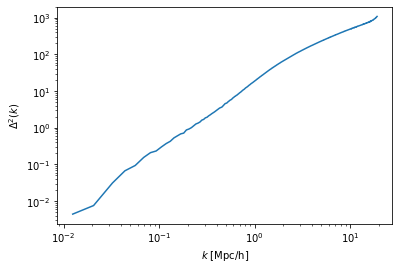

In [4]:
plt.plot(del2[0], del2[1])
plt.semilogx()
plt.semilogy()
plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$\Delta^2(k)$')

In [5]:
pk = del2[1] / (del2[0]**3) * (2 * np.pi**2)
# might be off by a constant, check the 2pi^2

Text(0, 0.5, '$P(k)$')

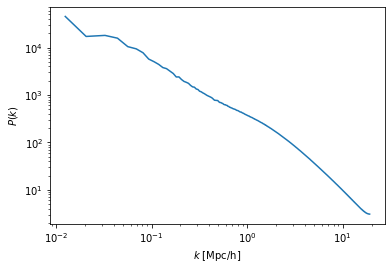

In [6]:
plt.plot(del2[0], pk.real)
plt.semilogy()
plt.semilogx()
plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$P(k)$')

This is now the expected behavior!

## From first principles

Alberto Krone-Martins points out that this is outlined in [Rocha+05](https://academic.oup.com/mnras/article/357/1/1/1033689).

In [7]:
nksmall = 100

In [8]:
whitenoise = np.random.random((nksmall, nksmall, nksmall))

In [9]:
fftwn = spf.fft(whitenoise)

Next step: need to make a 3 (2) D power spectrum.
This algorithm only works because the bins are spaced linearly in k.
It's commented out right now because it's very slow, though I'm not sure why.

In [ ]:
# # fftwn.real = pk.real * np.eye(len(pk))

# # placeholder = np.empty((nk, nk, nk))

# # for i in [nk - 1]:#range(nk):
# #     for j in range(nk)[:nksmall]:
# #         for k in range(nk)[:nksmall]:
# #             ka = int(np.sqrt(i + j + k))
# #             placeholder[i][j][k] = pk[int(ka)]

# placeholder = pk.real[:100, np.newaxis, np.newaxis] + pk.real[np.newaxis, :100, np.newaxis] + pk.real[np.newaxis, np.newaxis, :100]

In [ ]:
pk3d = np.sqrt(placeholder) * fftwn

In [ ]:
ifftwn = spf.ifft(fftwn)

In [ ]:
plt.imshow(ifftwn.real[-1], cmap='Spectral_r')

There are several issues with this:
1. If we'd done this with all higher order moments at once, it wouldn't be an issue, but we forgot that with a finite number of Fourier-space moments, we can't get a random field that looks like what we want if we give it white noise for the phase.  I suspect that even if we can combine the 2PCF and 3PCF, two moments won't be enough to overcome this.
2. Apparently no one believes linear bias between the matter and galaxy power spectra at small scales, so we can't get away with just matching using the moments of the matter distribution and a linear bias factor.  It's unclear whether our audience will be mollified with a more sophisticated galaxy bias model, i.e. higher order perturbation theory.  

Where to go from here:
1. _How do we generate realistic phases?_  We could calculate the 2PCF and keep the phases for many subsets of the particle data, then model the space of possible phases and draw new phases from that space.  But, generating new particle data from a single simulation is a very hot area of research right now, especially with machine learning, so I'm inclined to back off and accept being tied to the original simulation's positions/phases.  We could also revisit the wavelets idea for this.
2. _How do we account for the bias between the matter and galaxy distributions???_  We need to ask domain experts what they would believe.  My understanding is that HOD doesn't give them something they especially like either.  We need to find out what they would find more acceptable.

We should try to pursue the minimal-work subset of these problems that leads to a way to obtain mock catalog galaxy, because the alternative-to-inpainting part of the project shouldn't be held back by this.

## From first principles, part 2

I think the non-Python code below from Joachim Harnois-Deraps does almost the same thing as [Rocha+05](https://academic.oup.com/mnras/article/357/1/1/1033689).

In [ ]:
# !! The code is to generate a Gaussian stochastic field with a given 3d power spectrum
# !! written by T.T.Lu on Oct 13, 2006
# !! compile with 'efc GaussRandomField.f90 -L/opt/fftw-3.1.2_intel8/lib/ -lfftw3f -I/opt/fftw-3.1.2_intel8/include/ -o GaussRandomField.x'
# !! replace the fftw library by the corresponding one on the machine used

# Subroutine GaussRandomField_3d_r2c(den, box, nc, kg, delta2, nk)
#   implicit none

#   !! nc is the number of grids on each dimension
#   !! nt is the number of threads for openmp
#   !! nk is the number of points at the input power spectrum table
#   !! box is the physical size of the box
#   integer nc,nk
#   integer, parameter :: nt=1

#   real, dimension(nc+2,nc,nc) :: den
#   real, dimension(nk) :: pk,kg,delta2
# !  real, dimension(0:nk) :: factor
#   real, dimension(0:nc) :: factor
#   real, dimension(nc,nc,nc) :: x1,x2
#   real box

#   integer hc,it,i,j,k,k1,k2,kx,ky,kz,kpt
#   real pi,kr,w1,w2

#   external sfft3_r2c

#   write(*,*)'Called GaussRandomField_3d_r2c'


#   pi=acos(-1.)
#   hc=nc/2

#   do i=1,nk
#      pk(i)=delta2(i)/kg(i)**3*2*pi**2
#   enddo


#   !! generate whitenoise source
#   call random_number(x1(:,:,:))
#   call random_number(x2(:,:,:))

#   den=0
#   do k=1,nc
#      do j=1,nc
#         do i=1,nc
#            den(i,j,k)=sqrt(-2*log(x1(i,j,k)))*cos(2*pi*x2(i,j,k))
#         enddo
#      enddo
#   enddo
#   !write(*,*) 'step3'

#   call sfft3_r2c(den,nc,1)
#   !write(*,*) 'called  fft forward'

#   !write(*,*) '1 :Max = ' , maxval(den), 'min = ', minval(den)


#   factor=0
#   do k=1,nk
#      factor(k)=pk(k)/(box**3/nc**3)
#   enddo

#   kpt=nc/nt
#   !!$omp parallel do default(shared) &
#   !!$omp& private(it,i,j,k,kr,kri,kx,ky,kz,k1,k2,w1,w2,tmp)
#   do it=1,nt
#      do k=1+(it-1)*kpt,min(nc,it*kpt)
#         if (k .le. hc+1) then
#             kz=k-1
#         else
#             kz=k-1-nc
#         endif
#         do j=1,nc
#             if (j .le. hc+1) then
#                 ky=j-1
#             else
#                 ky=j-1-nc
#             endif
#             do i=1,nc+2,2
#                kx=(i-1)/2
#                kr=sqrt(kx**2.+ky**2+kz**2)
#                if(kr.ne.0) then
#                  k1=ceiling(kr)
#                  k2=k1+1
#                  w1=k1-kr
#                  w2=1-w1
#                  den(i,j,k)=den(i,j,k)*sqrt(factor(k1-1)*w1+factor(k2-1)*w2) !! interpolation causes problem
#                  den(i+1,j,k)=den(i+1,j,k)*sqrt(factor(k1-1)*w1+factor(k2-1)*w2)
#                else
#                  den(i,j,k)=den(i,j,k)*sqrt(factor(0))
#                  den(i+1,j,k)=den(i+1,j,k)*sqrt(factor(0))
#                endif
#            enddo
#         enddo
#      enddo
#   enddo
#   !!$omp end parallel do

# !  write(*,*) '2 :Max = ' , maxval(den), 'min = ', minval(den)
#   call sfft3_r2c(den,nc,-1)
# !  write(*,*) '3 :Max = ' , maxval(den), 'min = ', minval(den)

# !  write(*,*) 'called  fft backward'

#   return
# end subroutine GaussRandomField_3d_r2c

In [ ]:
randopk = pk
randopk.imag = spf.fft(whitenoise[0])

In [ ]:
newdel2rev = spf.ifft(randopk)
newdel2 = np.flip(newdel2rev.real)

In [ ]:
plt.plot((del2[0]**3 * 2 * np.pi**2) * del2[1])
plt.plot(newdel2 / (del2[0]**3 * 2 * np.pi**2))
plt.semilogx()
plt.semilogy()
plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$\Delta^2(k)$')

Aside from the left-right issue, I'm still not sure if this is what we want, but at least they're kind of talking to each other.
I still, however, don't know how to sample a 2D field from a 1D power spectrum. . .

# scratch after here

In [ ]:
nc = samps.shape[0]                # define how many cells your box has
boxlen = 50.0           # define length of box
Lambda = boxlen/4.0     # define an arbitrary wave length of a plane wave
dx = boxlen/nc          # get size of a cell

    # create plane wave density field
density_field = samps#np.zeros((nc, nc, nc), dtype='float')
for x in range(density_field.shape[0]):
    density_field[x,:] = np.cos(2*np.pi*x*dx/Lambda)

In [ ]:
    # get overdensity field
delta = density_field/np.mean(density_field) - 1

In [ ]:
    # get P(k) field: explot fft of data that is only real, not complex
delta_k = np.abs(np.fft.rfftn(delta).round())
Pk_field =  delta_k**2

In [ ]:
    # get 3d array of index integer distances to k = (0, 0, 0)
dist = np.minimum(np.arange(nc), np.arange(nc,0,-1))
dist_z = np.arange(nc//2+1)
dist *= dist
dist_z *= dist_z
dist_3d = np.sqrt(dist[:, None, None] + dist[:, None] + dist_z)

In [ ]:
    # get unique distances and index which any distance stored in dist_3d 
    # will have in "distances" array
distances, _ = np.unique(dist_3d, return_inverse=True)

    # average P(kx, ky, kz) to P(|k|)
Pk = np.bincount(_, weights=Pk_field.ravel())/np.bincount(_)

    # compute "phyical" values of k
dk = 2*np.pi/boxlen
k = distances*dk

    # plot results
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
ax1.plot(k, Pk, label=r'$P(\mathbf{k})$')

In [ ]:
img = samps

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()          

In [ ]:
def compute_results(array, Nbins=20):
#     print(np.shape(array))
#     np.random.seed(rseed)
    bins = 10. ** np.linspace(np.log10(1. / 50000.), np.log10(10.), Nbins)
#     results = [bins]
    print(np.shape(bins))
    results = two_point(array, bins)
    print(np.shape(corr))
#         (array['Ra'],
#                                            array['Dec'],
#                                            bins=bins,
#                                            method=method,
#                                            Nbootstraps=Nbootstraps)
    return (bins, results)
#

In [ ]:
(bins, corr) = compute_results(samps)

In [ ]:
bins

In [ ]:
corr

In [ ]:
plt.plot(bins, corr)

In [ ]:
bin_centers = 0.5 * (bins[1:] + bins[:-1])
#
bin_centers = bin_centers[np.where(np.isnan(corr)==False)]
corr = corr[np.where(np.isnan(corr)==False)]
corr_err = corr_err[np.where(np.isnan(corr)==False)]
#
# Export the TPCF data to an numpy array
tpcf = np.transpose(np.array([bin_centers, corr, corr_err]))
#
# Print the TPCF file
# print(tpcf)
#
# Export the TPCF data to a file
# np.savetxt('./Data/ngc1566_astroml_tpcf.dat', tpcf)
#
# Import fitting process
from scipy.optimize import curve_fit
#
# Define the fitting function
def fitfunc(x, a, b, c):
    return a*(x/b)**c
#
# Plot the Landy-Szalay TPCF and its fit
popt, pcov = curve_fit(fitfunc, bin_centers[1:10], corr[1:10])
#

still working on this. . . 